# PyTorch webinar - top species subset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from plantclef.spark import get_spark

spark = get_spark(
    cores=8,
    memory="20g",
)
display(spark)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/19 09:31:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/03/19 09:31:28 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [3]:
import os
from pathlib import Path

# Get list of stored filed in cloud bucket
root = Path(os.path.expanduser("~"))
! date

Wed Mar 19 09:31:31 AM EDT 2025


In [6]:
# Path and dataset names
data_path = f"{root}/p-dsgt_clef2025-0/shared/plantclef/data/parquet/"

# Define the path to the train and test parquet files
train_path = f"{data_path}/subset_top5_train"
test_path = f"{data_path}/test"

# Read the parquet files into a spark DataFrame
train_df = spark.read.parquet(train_path)
test_df = spark.read.parquet(test_path)

# Show the data
train_df.printSchema()
train_df.show(n=5)
test_df.show(n=5)

root
 |-- species_id: integer (nullable = true)
 |-- image_name: string (nullable = true)
 |-- path: string (nullable = true)
 |-- data: binary (nullable = true)
 |-- organ: string (nullable = true)
 |-- obs_id: long (nullable = true)
 |-- license: string (nullable = true)
 |-- partner: string (nullable = true)
 |-- author: string (nullable = true)
 |-- altitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- gbif_species_id: string (nullable = true)
 |-- species: string (nullable = true)
 |-- genus: string (nullable = true)
 |-- family: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- references: string (nullable = true)
 |-- url: string (nullable = true)
 |-- learn_tag: string (nullable = true)
 |-- image_backup_url: string (nullable = true)



+----------+--------------------+--------------------+--------------------+------+----------+--------------------+-------+-----------------+--------+-----------------+------------+---------------+--------------------+--------+--------+--------+-----------+--------------------+--------------------+---------+--------------------+
|species_id|          image_name|                path|                data| organ|    obs_id|             license|partner|           author|altitude|         latitude|   longitude|gbif_species_id|             species|   genus|  family| dataset|  publisher|          references|                 url|learn_tag|    image_backup_url|
+----------+--------------------+--------------------+--------------------+------+----------+--------------------+-------+-----------------+--------+-----------------+------------+---------------+--------------------+--------+--------+--------+-----------+--------------------+--------------------+---------+--------------------+
|   174162

+--------------------+--------------------+--------------------+
|          image_name|                path|                data|
+--------------------+--------------------+--------------------+
|CBN-Pla-B3-201907...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-PdlC-E5-20180...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-PdlC-B1-20140...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-Pla-D4-201507...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-PdlC-F3-20190...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [7]:
# interesting test images
images = [
    "CBN-Pyr-03-20230706.jpg",
    "OPTMix-012-P2-207-20231201.jpg",
    "OPTMix-0178-P1-661-20231006.jpg",
    "OPTMix-0333-P2-115-20231212.jpg",
    "OPTMix-0598-P4-104-20231207.jpg",
    "RNNB-1-4-20240117.jpg",
    "RNNB-1-7-20230512.jpg",
    "RNNB-1-8-20230512.jpg",
    "RNNB-4-2-20240118.jpg",
    "RNNB-8-8-20240118.jpg",
    "CBN-can-E6-20230706.jpg",
    "CBN-Pla-A3-20140812.jpg",
]

In [24]:
from pyspark.sql import functions as F

# get subset of images
sub_test_df = test_df.where(F.col("image_name").isin(images)).cache()
sub_test_df.show(n=12)
sub_test_df.count()

+--------------------+--------------------+--------------------+
|          image_name|                path|                data|
+--------------------+--------------------+--------------------+
|RNNB-1-7-20230512...|/test/data/PlantC...|[FF D8 FF DB 00 4...|
|RNNB-1-8-20230512...|/test/data/PlantC...|[FF D8 FF DB 00 4...|
|RNNB-8-8-20240118...|/test/data/PlantC...|[FF D8 FF DB 00 4...|
|RNNB-1-4-20240117...|/test/data/PlantC...|[FF D8 FF DB 00 4...|
|CBN-Pyr-03-202307...|/test/data/PlantC...|[FF D8 FF DB 00 4...|
|CBN-can-E6-202307...|/test/data/PlantC...|[FF D8 FF DB 00 4...|
|CBN-Pla-A3-201408...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|OPTMix-0333-P2-11...|/test/data/PlantC...|[FF D8 FF DB 00 4...|
|OPTMix-012-P2-207...|/test/data/PlantC...|[FF D8 FF DB 00 4...|
|RNNB-4-2-20240118...|/test/data/PlantC...|[FF D8 FF DB 00 4...|
|OPTMix-0178-P1-66...|/test/data/PlantC...|[FF D8 FF DB 00 4...|
|OPTMix-0598-P4-10...|/test/data/PlantC...|[FF D8 FF DB 00 4...|
+--------------------+---

12

In [25]:
# select sample of test data
sample_df = test_df.orderBy(F.rand(seed=42)).limit(188).cache()
sample_test_df = sample_df.union(sub_test_df).cache()
sample_test_df.show(n=12)
sample_test_df.count()

+--------------------+--------------------+--------------------+
|          image_name|                path|                data|
+--------------------+--------------------+--------------------+
|CBN-PdlC-C4-20180...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|LISAH-BOU-0-30-20...|/test/data/PlantC...|[FF D8 FF DB 00 4...|
|CBN-PdlC-C4-20140...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-Pla-D5-201507...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|LISAH-BOU-0-109-2...|/test/data/PlantC...|[FF D8 FF DB 00 4...|
|LISAH-BVD-0-301-2...|/test/data/PlantC...|[FF D8 FF DB 00 4...|
|CBN-PdlC-C2-20180...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|LISAH-BVD-0-192-2...|/test/data/PlantC...|[FF D8 FF DB 00 4...|
|CBN-Pla-F1-201509...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-PdlC-F5-20150...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-PdlC-E1-20170...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
|CBN-Pla-E1-201908...|/test/data/PlantC...|[FF D8 FF E0 00 1...|
+--------------------+---

200

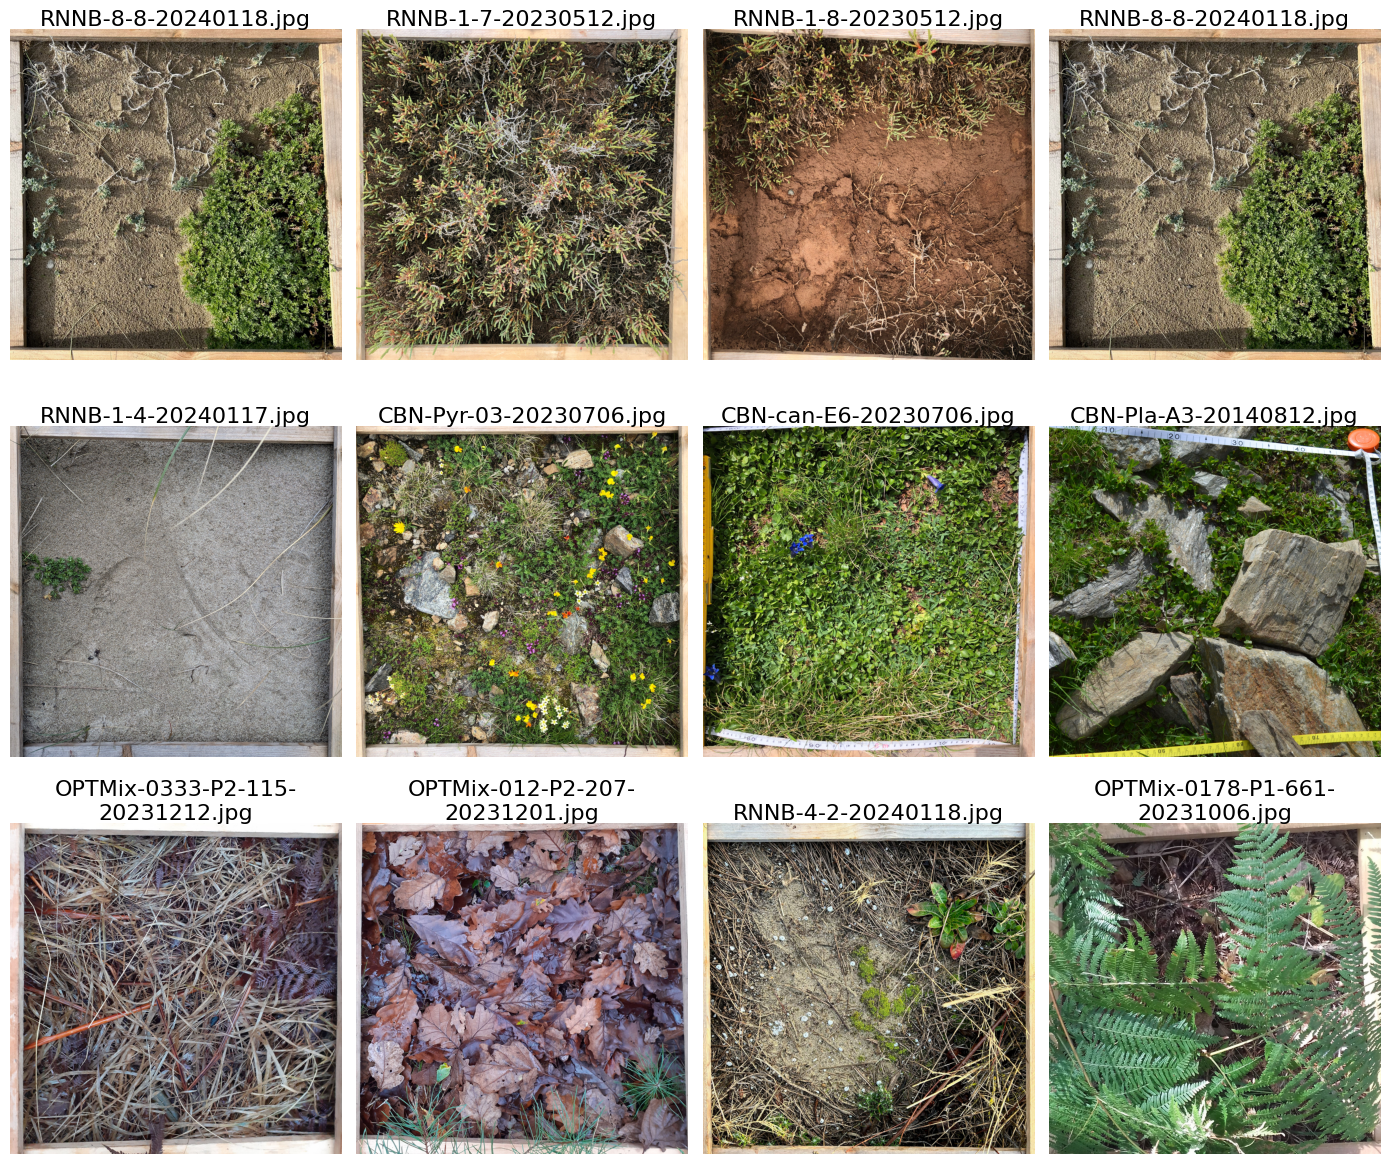

In [27]:
from plantclef.plotting import plot_images_from_binary

subset_df = sample_test_df.where(F.col("image_name").isin(images)).cache()

# display the images in a grid with binomial names
plot_images_from_binary(
    subset_df,
    data_col="data",
    label_col="image_name",
    grid_size=(3, 4),
    crop_square=True,
    figsize=(14, 12),
    dpi=100,
)

In [28]:
output_path = f"{data_path}/test_2025_pytorch_webinar"
subset_df.write.mode("overwrite").parquet(output_path)